# 🔧 Feature Engineering for IBM HR Analytics: Employee Attrition & Performance 

## Importing Dependencies

In [1]:
import sys
import os
import warnings

warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath(os.path.join("..", "scripts", "utils")))

%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import boxcox, mstats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import visualization as viz
from data_helpers import get_cols_names, print_cols_summary

In [2]:
DATA_PATH = os.path.join("..", "data", "raw", "hr_employee_attrition.csv")

# Setting parameters
pd.set_option("display.max_columns", 40)
pd.set_option("display.max_rows", 40)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

plt.style.use("ggplot")
sns.set_style("darkgrid", {"grid.color": ".8"})

## Data Loading

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [52]:
cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols = get_cols_names(df)
target_col = "Attrition"

## Winsorization & Log Transformation to Handle Outliers and Fix Skewness

We apply **log transformation** and **winsorization** to the features that have high skewness to handle **outliers** and fix **skewness**.


Column: DistanceFromHome
Original Skewness: 0.9581179956568269
Log Transformed Skewness after winsorization: -0.029120785364396513

Column: MonthlyIncome
Original Skewness: 1.3698166808390662
Log Transformed Skewness after winsorization: 0.3176856148216935

Column: PercentSalaryHike
Original Skewness: 0.8211279755780908
Log Transformed Skewness after winsorization: 0.5135425214775441

Column: TotalWorkingYears
Original Skewness: 1.1171718528128527
Log Transformed Skewness after winsorization: -0.5070181582668091

Column: YearsAtCompany
Original Skewness: 1.7645294543422085
Log Transformed Skewness after winsorization: -0.22286218323009538

Column: YearsInCurrentRole
Original Skewness: 0.9173631562908262
Log Transformed Skewness after winsorization: -0.3932633576146813

Column: YearsSinceLastPromotion
Original Skewness: 1.9842899833524859
Log Transformed Skewness after winsorization: 0.7122359740239425

Column: YearsWithCurrManager
Original Skewness: 0.8334509919918475
Log Transformed 

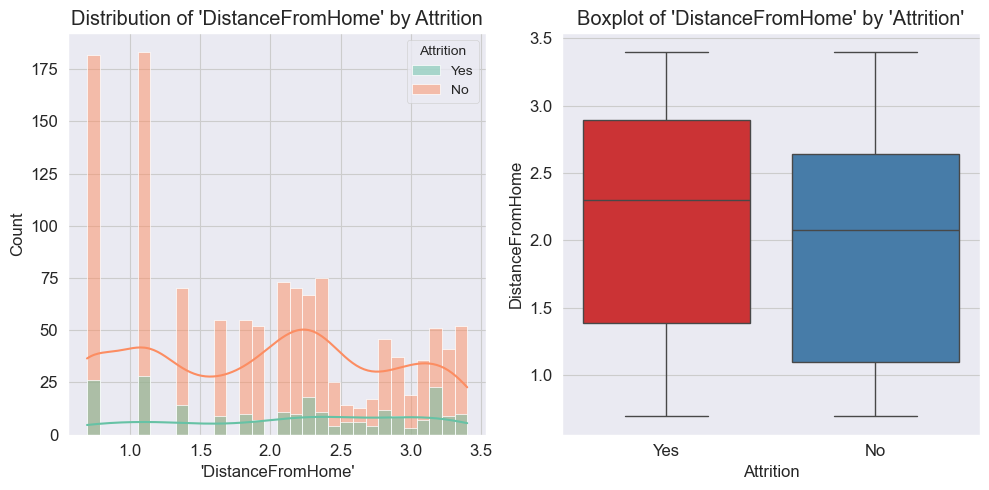

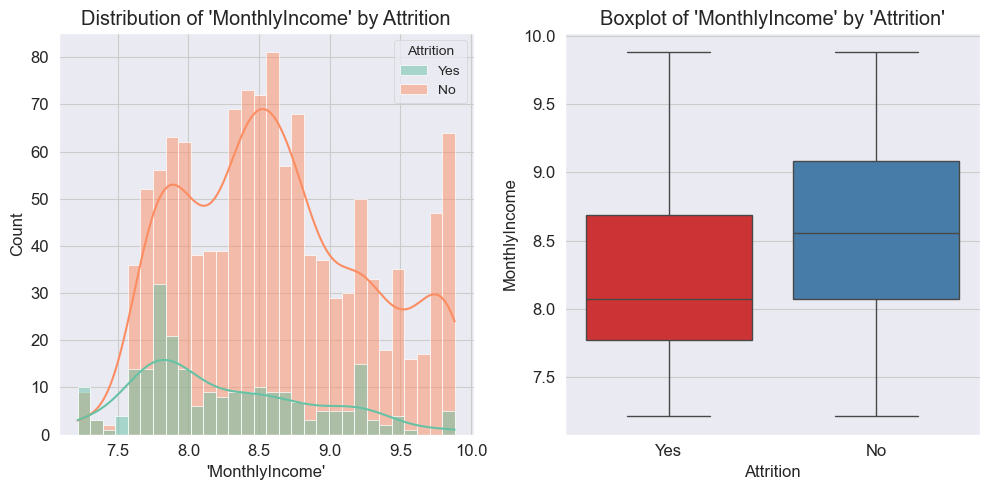

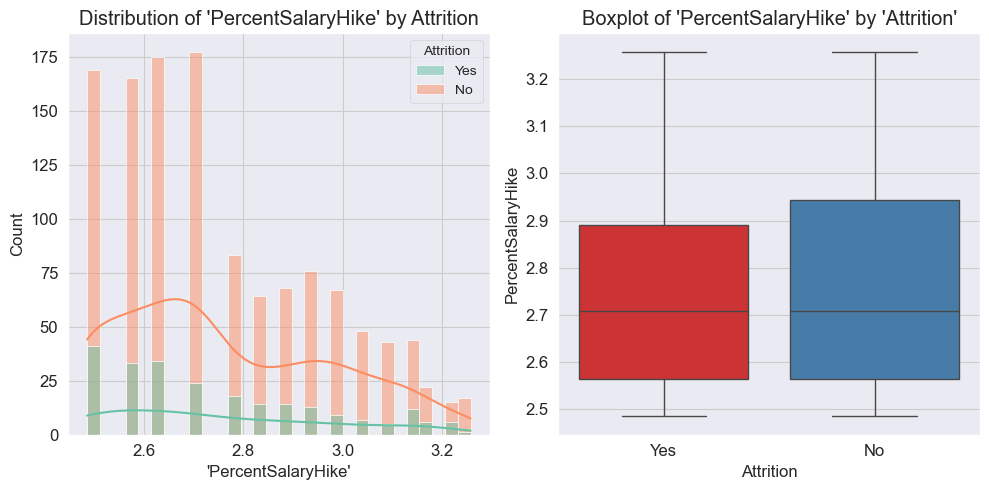

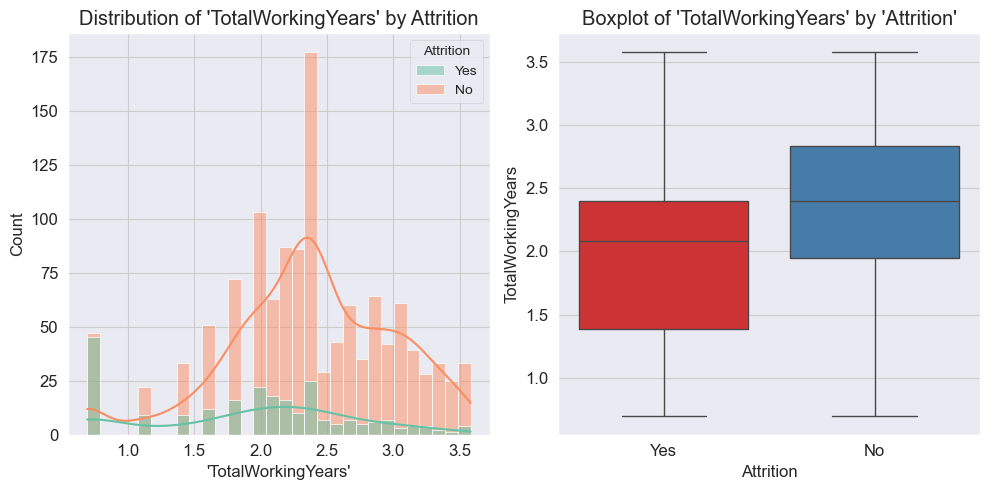

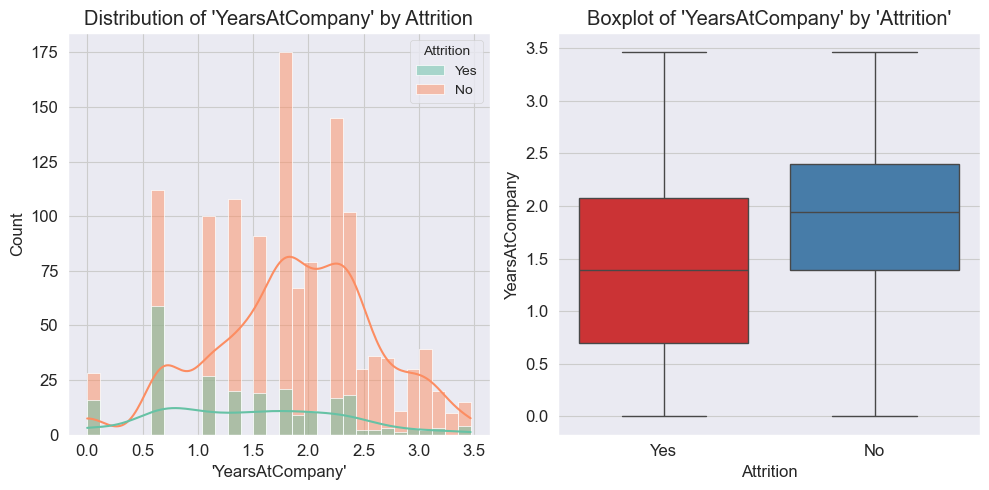

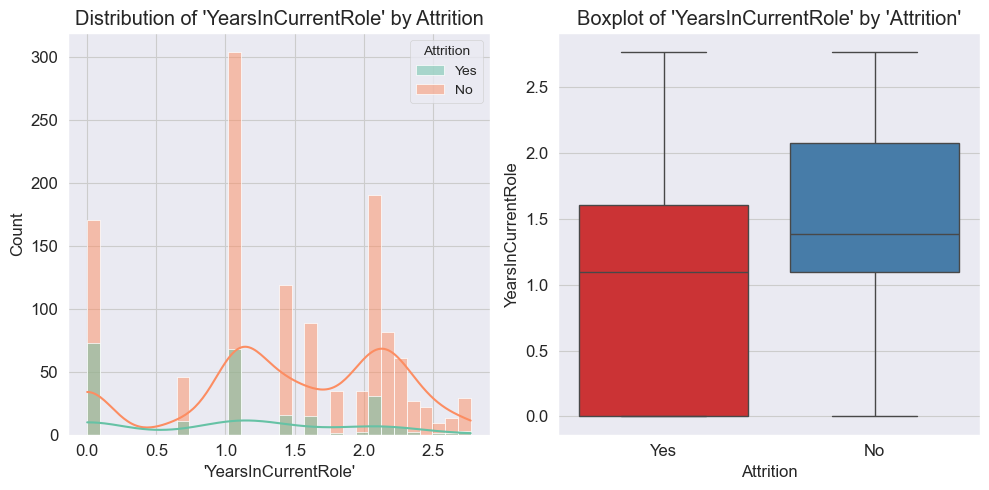

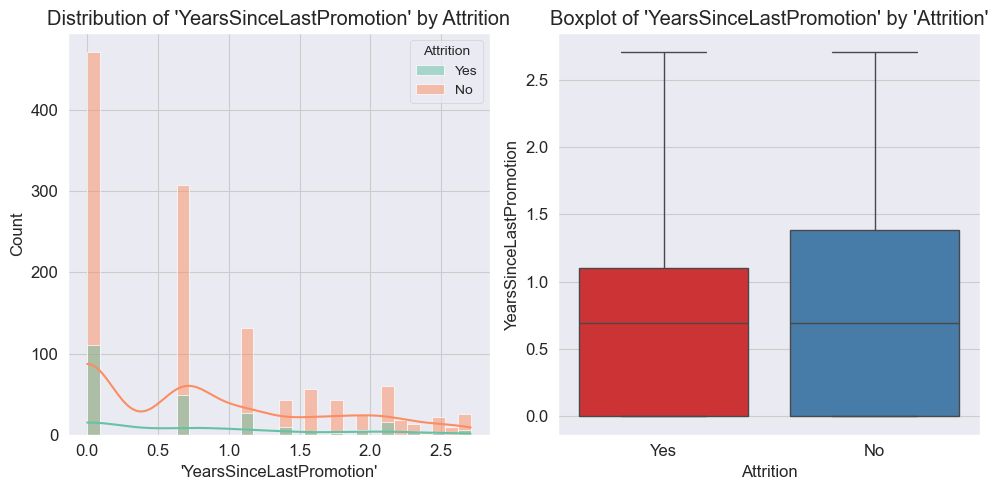

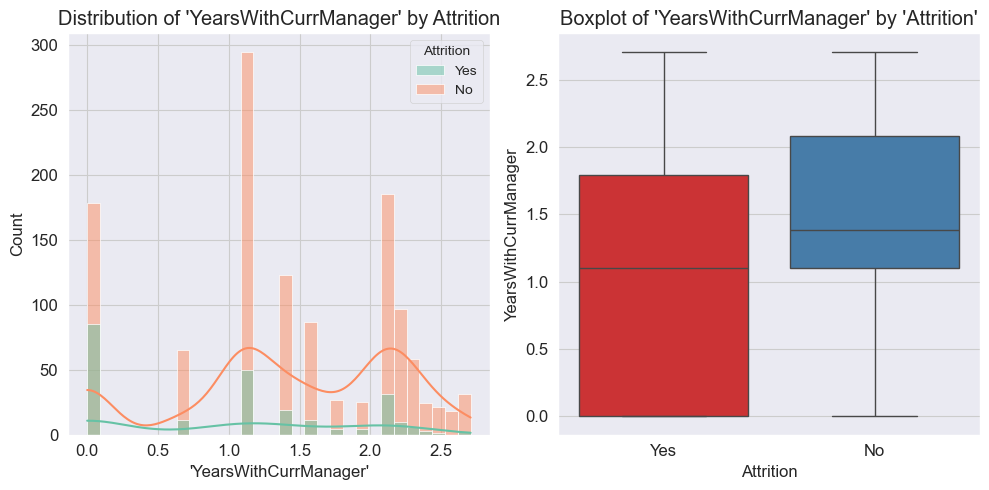

In [53]:
cols_with_high_skew = [col for col in num_cols if df[col].skew() > 0.7 ]
new_df = df.copy()

# Winsorization & Log Transformation to reduce skewness
for col in cols_with_high_skew:
  new_df[col] = mstats.winsorize(new_df[col], limits=[0.01, 0.01]) 
  new_df[col] = np.log1p(new_df[col]) 
  
  print(f"\nColumn: {col}")
  print("Original Skewness:", df[col].skew())
  print("Log Transformed Skewness after winsorization:", new_df[col].skew())
  
for col in cols_with_high_skew:
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  viz.num_distribution(new_df, col_name=col, hue=target_col, ax=axes[0])
  viz.boxplot_by_target(new_df, target_col, col, ax=axes[1])
  # viz.save_figure(fig, f"{col}_analysis", "log_num_features_analysis")

  plt.tight_layout()
  plt.show()

## Adding New features

In [ ]:
# Trying to create new features
new_df["NEW_IncomeStability"] = new_df["MonthlyIncome"] / new_df["MonthlyRate"]
new_df["NEW_OvertimeImpact"] = (new_df["OverTime"] == "Yes").astype(int) * new_df["JobSatisfaction"]
new_df["NEW_AttritionRiskScore"] = (
  (new_df["OverTime"] == "Yes").astype(int) * 2 + 
  (4 - new_df["JobSatisfaction"]) + 
  (4 - new_df["WorkLifeBalance"]) + 
  (new_df["YearsSinceLastPromotion"] > 5).astype(int) * 2
)
new_df["NEW_FirstJob"] = (new_df["NumCompaniesWorked"] == 0).astype(int)
new_df["NEW_FrequentTraveler"] = new_df["BusinessTravel"].apply(lambda x: 1 if x == "Travel_Frequently" else 0)
new_df["NEW_MarriedWithHighWorkload"] = ((new_df["MaritalStatus"] == "Married") & (new_df["OverTime"] == "Yes")).astype(int)

In [55]:
cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols = get_cols_names(new_df)
print_cols_summary(new_df, cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols)

Categorical columns (27) (including numeric-looking categorical columns): ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime', 'Education', 'EmployeeCount', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'NEW_OvertimeImpact', 'NEW_AttritionRiskScore', 'NEW_FirstJob', 'NEW_FrequentTraveler', 'NEW_MarriedWithHighWorkload']

From them numeric-looking categorical columns (18): ['Education', 'EmployeeCount', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'NEW_OvertimeImpact', 'NEW_AttritionRiskScore', 'NEW_FirstJob', 'NEW_FrequentTraveler', 'NEW_MarriedWithHighWorkl

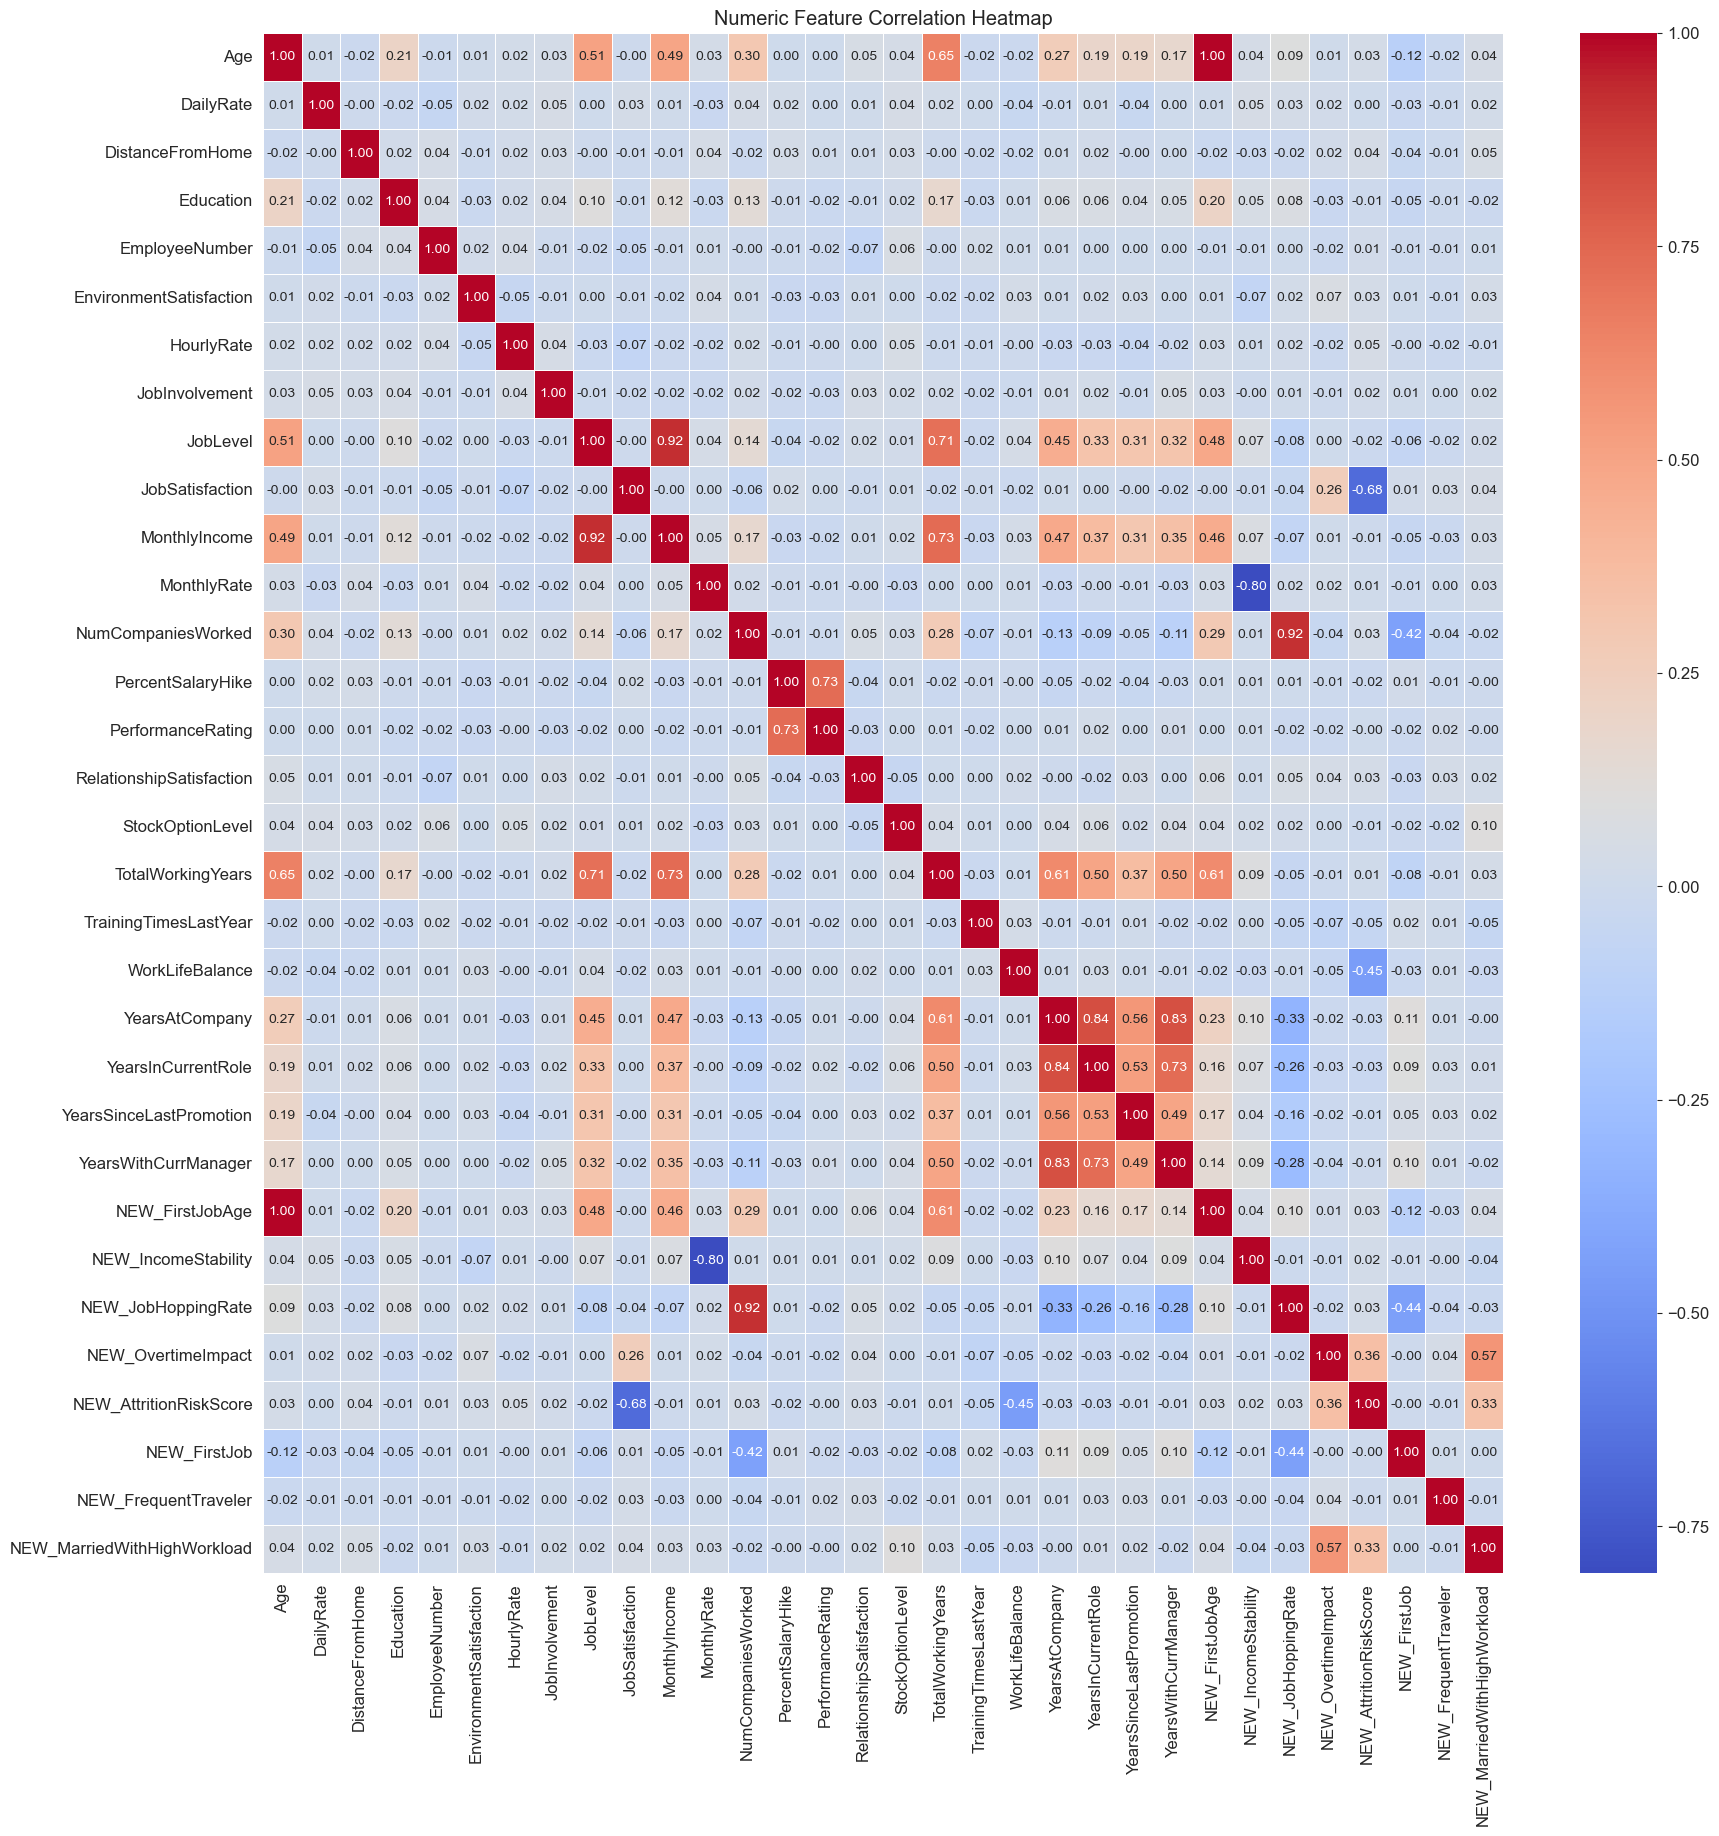

In [56]:
plt.figure(figsize=(20, 20))
sns.heatmap(new_df.drop(columns=["EmployeeCount", "StandardHours"]).corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

### Removing Highly Correlated Features

In [62]:
corr_th = 0.85
corr = new_df.corr(numeric_only=True)
cor_matrix = corr.abs()
upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

highly_correlated_features = set()
for col in upper_triangle_matrix.columns:
  if any(upper_triangle_matrix[col] > corr_th):
    highly_correlated_features.add(col)

print(list(highly_correlated_features))
new_df.drop(columns=list(highly_correlated_features), inplace=True)

['MonthlyIncome', 'NEW_FirstJobAge', 'NEW_JobHoppingRate']
